In [24]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.autograd import grad
from torch.utils.data import Dataset

class Corner_Singularity_2D(Dataset):
    def __init__(self, nb_points_in_omega=1000, nb_points_on_boundary=500, lower_bound_xy=[-1, -1], uper_bound_xy=[1, 1]):

        self.lower_bound_xy = lower_bound_xy
        self.upper_bound_xy = uper_bound_xy
        self.squared_grid_size = 19

        self.nb_points_in_omega = nb_points_in_omega
        self.nb_points_on_boundary = nb_points_on_boundary
        self.omega_coordinates, self.boundary_coordinates = self._create_points_in_domain(self.nb_points_in_omega, self.nb_points_on_boundary, self.lower_bound_xy, self.upper_bound_xy)

        self.omega_uniform_coordinates, self.boundary_uniform_coordinates, self.uniform_all_points = self._create_uniform_grid([self.squared_grid_size, self.squared_grid_size], self.lower_bound_xy, self.upper_bound_xy)

    def __getitem__(self, index):
        return self.omega_coordinates[index]
    
    def __len__(self):
        return self.nb_points_in_omega + self.nb_points_on_boundary

    def  _create_points_in_domain(self, nb_points_in_omega, nb_points_on_boundary, lower_bound_xy, upper_bound_xy, tol_boundary_corner=1e-3, tol_boundary_square=1e-6):
        xmin, ymin = lower_bound_xy
        xmax, ymax = upper_bound_xy
        x_points_in_omega = np.random.uniform(xmin+tol_boundary_square, xmax-tol_boundary_square, nb_points_in_omega)
        y_points_in_omega = np.random.uniform(ymin+tol_boundary_square, ymax-tol_boundary_square, nb_points_in_omega)
        # x_points_in_omega = np.concatenate((x_points_in_omega, np.random.uniform(-1+tol_boundary_square, 0, nb_points_in_omega)))
        # y_points_in_omega = np.concatenate((y_points_in_omega, np.random.uniform(-0.2, 0.2, nb_points_in_omega)))
        omega_coordinates = np.vstack((x_points_in_omega, y_points_in_omega)).T

        corner_singularity_mask = ~((-tol_boundary_corner <= omega_coordinates[:, 1]) &
                                    (omega_coordinates[:, 1] <= tol_boundary_corner) &
                                    (0 <= omega_coordinates[:, 0]) &
                                    (omega_coordinates[:, 0] <= xmax-tol_boundary_square))
        omega_coordinates = omega_coordinates[corner_singularity_mask]

        nb_points_per_boundary = nb_points_on_boundary // 5
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.random.uniform(ymin, ymin+tol_boundary_square, nb_points_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, nb_points_per_boundary), np.random.uniform(ymax-tol_boundary_square, ymax, nb_points_per_boundary)
        x_right, y_right = np.random.uniform(xmax-tol_boundary_square, xmax, nb_points_per_boundary), np.random.uniform(ymin+tol_boundary_square, ymax-tol_boundary_square, nb_points_per_boundary)
        x_left, y_left = np.random.uniform(xmin, xmin+tol_boundary_square, nb_points_per_boundary), np.random.uniform(ymin+tol_boundary_square, ymax-tol_boundary_square, nb_points_per_boundary)
        x_corner, y_corner = np.random.uniform(0, xmax-tol_boundary_square, nb_points_per_boundary), np.zeros(nb_points_per_boundary)

        x_boundary = np.concatenate((x_bottom, x_top, x_right, x_left, x_corner))
        y_boundary = np.concatenate((y_bottom, y_top, y_right, y_left, y_corner))

        boundary_coordinates = np.vstack((x_boundary, y_boundary)).T

        self.nb_points_on_boundary = len(boundary_coordinates)
        self.nb_points_in_omega = len(omega_coordinates)

        return omega_coordinates, boundary_coordinates

    def _create_uniform_grid(self, grid_size, lower_bound_xy, upper_bound_xy):
        mesh = RectangleMesh(Point(lower_bound_xy[0], lower_bound_xy[1]), Point(upper_bound_xy[0], upper_bound_xy[1]), grid_size[0], grid_size[1])
        mesh_coordinates = mesh.coordinates()

        boundary_mask = [(x, y) for x, y in mesh_coordinates if ((x == -1) or (x == 1) or (y == -1) or (y == 1))]
        extra_points_for_boundary = [(x, 0) for x in np.linspace(0, 1, 40)] 
        boundary_mask.extend(extra_points_for_boundary)
        omega_mask = [(x, y) for x, y in mesh_coordinates if not ((y == 0 and 0 <= x <= 1) or (x == -1) or (x == 1) or (y == -1) or (y == 1))]

        boundary_coordinates = np.array(boundary_mask)
        boundary_coordinates = boundary_coordinates[np.lexsort((boundary_coordinates[:, 0], boundary_coordinates[:, 1]))]
        omega_coordinates = np.array(omega_mask)

        return omega_coordinates, boundary_coordinates, mesh_coordinates

    def plot_domain(self, label=True):
        plt.scatter(self.omega_coordinates[:, 0], self.omega_coordinates[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_coordinates[:, 0], self.boundary_coordinates[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        if label:
            plt.legend()
        plt.show()   

In [25]:
# DEVICE CHECK #

if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


In [26]:
import sys
import os
import importlib
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'ModelsNN'))
import recurrent_nn as rnn
importlib.reload(rnn)

model = rnn.RitzModel(2)
total_params = model.nb_params
print(f"Le modèle possède : {total_params} paramètres")

Le modèle possède : 921 paramètres


In [27]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    negative_mask = phi < 0
    phi[negative_mask] += 2 * np.pi
    return(rho, phi)

def u_true(x):
    x, y = x[:, 0], x[:, 1]
    r, theta = cart2pol(x, y)
    return r**(1/2) * np.sin(theta/2)

def f_true(x):
    return np.zeros(x.shape[0])

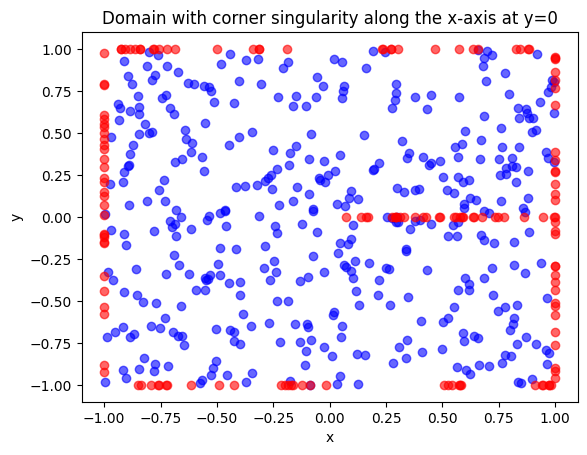

In [28]:
# Always check that we have the corner singularity in the domain
omega = Corner_Singularity_2D(400, 150)
omega.plot_domain(False)
ix_omega = omega.omega_coordinates
ix_boundary = omega.boundary_coordinates
true_boundary = torch.FloatTensor(u_true(ix_boundary)).reshape(len(ix_boundary),1) 

In [29]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [30]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self):
        super(DeepRitzLoss, self).__init__()
        self.mse = torch.nn.MSELoss()
        self.loss = 0.
    
    def forward(self, x_in_omega, output_ux_in_omega, true_operator_x, output_on_boundary, true_value_on_boundary, boundary_regulizer=500):
        grad_u = grad(flat(output_ux_in_omega), x_in_omega, create_graph=True, allow_unused=True)[0]

        physical_term1 = torch.abs(grad_u)**2
        physical_term2 = -true_operator_x*output_ux_in_omega
        boundary_loss = self.mse(output_on_boundary, true_value_on_boundary)

        total_loss = torch.mean(0.5*physical_term1) + torch.mean(physical_term2) + boundary_regulizer*boundary_loss
        self.loss = total_loss.item()
        return total_loss

In [31]:
def closure_lbfgs():
    model_optimizer.zero_grad()
    integration_grid = Corner_Singularity_2D(200, 100)
    mc_integration_points_in_omega = torch.FloatTensor(integration_grid.omega_coordinates)
    mc_integration_points_on_boundary = torch.FloatTensor(integration_grid.boundary_coordinates)
    mc_true_boundary = torch.FloatTensor(u_true(mc_integration_points_on_boundary)).reshape(integration_grid.nb_points_on_boundary, 1)

    mc_integration_points_in_omega.requires_grad = True
    mc_integration_points_on_boundary.requires_grad = True

    fmc_integration_points = torch.FloatTensor(f_true(mc_integration_points_in_omega)).reshape(integration_grid.nb_points_in_omega, 1)
    fmc_integration_points.requires_grad = True

    mc_output_omega = ritz_model(mc_integration_points_in_omega)
    mc_output_boundary = ritz_model(mc_integration_points_on_boundary)

    loss = criterion(mc_integration_points_in_omega, mc_output_omega, fmc_integration_points, mc_output_boundary, mc_true_boundary, 500)
    loss.backward()
    
    return loss

In [127]:
ritz_model = rnn.RitzModel(2)
criterion = DeepRitzLoss()
model_optimizer = torch.optim.Adam(ritz_model.parameters(), lr=0.0005)
n_iter_adam = 4000
n_iter_lbfgs = 400

train_loss_per_epoch = []

ritz_model.train()
for iter_i in range(n_iter_adam):
    train_loss_epoch_i = 0

    integration_grid = Corner_Singularity_2D(100, 50)
    mc_integration_points_in_omega = torch.FloatTensor(integration_grid.omega_coordinates)
    mc_integration_points_on_boundary = torch.FloatTensor(integration_grid.boundary_coordinates)
    mc_true_boundary = torch.FloatTensor(u_true(mc_integration_points_on_boundary)).reshape(integration_grid.nb_points_on_boundary, 1)

    mc_integration_points_in_omega.requires_grad = True
    mc_integration_points_on_boundary.requires_grad = True

    fmc_integration_points = torch.FloatTensor(f_true(mc_integration_points_in_omega)).reshape(integration_grid.nb_points_in_omega, 1)
    fmc_integration_points.requires_grad = True

    model_optimizer.zero_grad()

    mc_output_omega = ritz_model(mc_integration_points_in_omega)
    mc_output_boundary = ritz_model(mc_integration_points_on_boundary)
    
    total_loss = criterion(x_in_omega=mc_integration_points_in_omega, output_ux_in_omega=mc_output_omega, true_operator_x=fmc_integration_points, output_on_boundary=mc_output_boundary, true_value_on_boundary=mc_true_boundary, boundary_regulizer=500)
    train_loss_epoch_i += total_loss.item()
    
    total_loss.backward()
    model_optimizer.step()

    train_loss_per_epoch.append(train_loss_epoch_i)

    if iter_i % 25 == 0:
        print(f"Iter {iter_i}, Loss: {train_loss_epoch_i}")

# model_optimizer = torch.optim.LBFGS(ritz_model.parameters(), lr=0.0005)
# for iter_i in range(n_iter_lbfgs):
#     train_loss_epoch_i = 0
    
#     total_loss = model_optimizer.step(closure_lbfgs)
#     train_loss_epoch_i += total_loss.item()

#     train_loss_per_epoch.append(train_loss_epoch_i)

#     if iter_i % 25 == 0:
#         print(f"Iter {iter_i}, Loss: {train_loss_epoch_i}")

Iter 0, Loss: 275.1197814941406
Iter 25, Loss: 218.4139404296875
Iter 50, Loss: 193.4062957763672
Iter 75, Loss: 168.89846801757812
Iter 100, Loss: 130.01651000976562
Iter 125, Loss: 98.55923461914062
Iter 150, Loss: 41.36373519897461
Iter 175, Loss: 31.040990829467773
Iter 200, Loss: 24.585277557373047
Iter 225, Loss: 22.29056167602539
Iter 250, Loss: 24.509939193725586
Iter 275, Loss: 21.058399200439453
Iter 300, Loss: 24.417139053344727
Iter 325, Loss: 21.32172393798828
Iter 350, Loss: 26.554834365844727
Iter 375, Loss: 22.474512100219727
Iter 400, Loss: 20.74052619934082
Iter 425, Loss: 19.0799617767334
Iter 450, Loss: 20.985830307006836
Iter 475, Loss: 21.5926456451416
Iter 500, Loss: 18.15515899658203
Iter 525, Loss: 19.67008399963379
Iter 550, Loss: 17.109960556030273
Iter 575, Loss: 15.347311019897461
Iter 600, Loss: 19.283475875854492
Iter 625, Loss: 17.289602279663086
Iter 650, Loss: 12.784981727600098
Iter 675, Loss: 18.642440795898438
Iter 700, Loss: 14.886528015136719
Iter

In [123]:
def assess_solution(model, evaluation_domain, plot=False):
    squared_grid_size = evaluation_domain.squared_grid_size
    evaluation_domain_points = torch.FloatTensor(evaluation_domain.uniform_all_points)

    model.eval()

    u_pred = (model(evaluation_domain_points).detach().numpy()).reshape(squared_grid_size+1, squared_grid_size+1)
    u_exact = (u_true(evaluation_domain_points).detach().numpy()).reshape(squared_grid_size+1, squared_grid_size+1)

    diff_abs = np.abs(u_exact - u_pred)

    print(f"Mean absolute difference: {np.mean(diff_abs)}")

    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        im0 = axes[0].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1])
        axes[0].set_title('Exact solution')
        fig.colorbar(im0, ax=axes[0], shrink=0.6)

        im1 = axes[1].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1])
        axes[1].set_title('Predicted solution')
        fig.colorbar(im1, ax=axes[1], shrink=0.6)

        im2 = axes[2].imshow(diff_abs, cmap='jet', extent=[-1, 1, -1, 1])
        axes[2].set_title('Absolute difference')
        fig.colorbar(im2, ax=axes[2], shrink=0.6)

        plt.tight_layout()
        plt.show()

Mean absolute difference: 0.17881137132644653


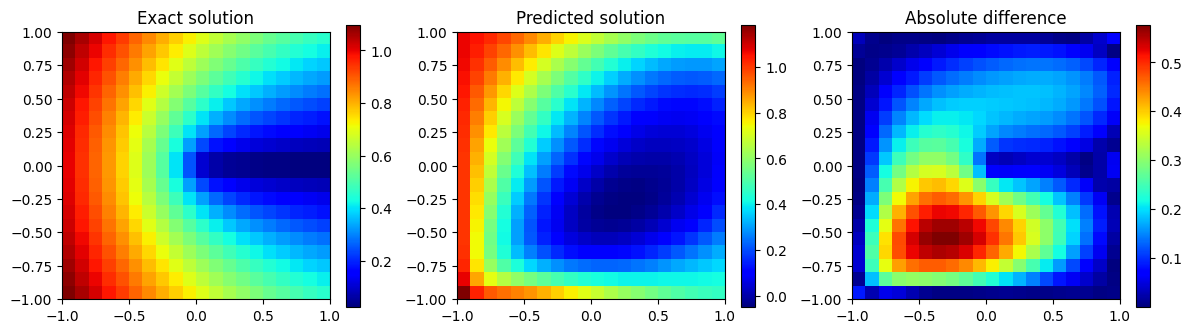

In [128]:
assess_solution(ritz_model, Corner_Singularity_2D(), plot=True)